# Learning the Inverse Discrete Fourier Transform from Undrsampled Signals

The Inverse Discrete Fourier Transform (IDFT) is used for reconstructing images acquired in k-space (Fourier domain). In this tutorial, we will try to compute the IDFT from undersampled k-sapces. This tutorial is similar to the previous one, but we use a multi-layer neural network to try to compensate for the undersampled k-sapce.

The goal of this tutorial is:
  - Illustrate a framework that can be used to compute the IDFT from undersampled k-spaces. This may lead to compressed sensing applications.

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('xtick', labelsize=4) 
matplotlib.rc('ytick', labelsize=4) 
import matplotlib.pylab as plt
import numpy as np
import os

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.noise import GaussianNoise
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import sys

MY_UTILS_PATH = '../Modules/'
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import ipt_utils 
np.random.seed(302)

Using TensorFlow backend.


## Loading 1D Signals

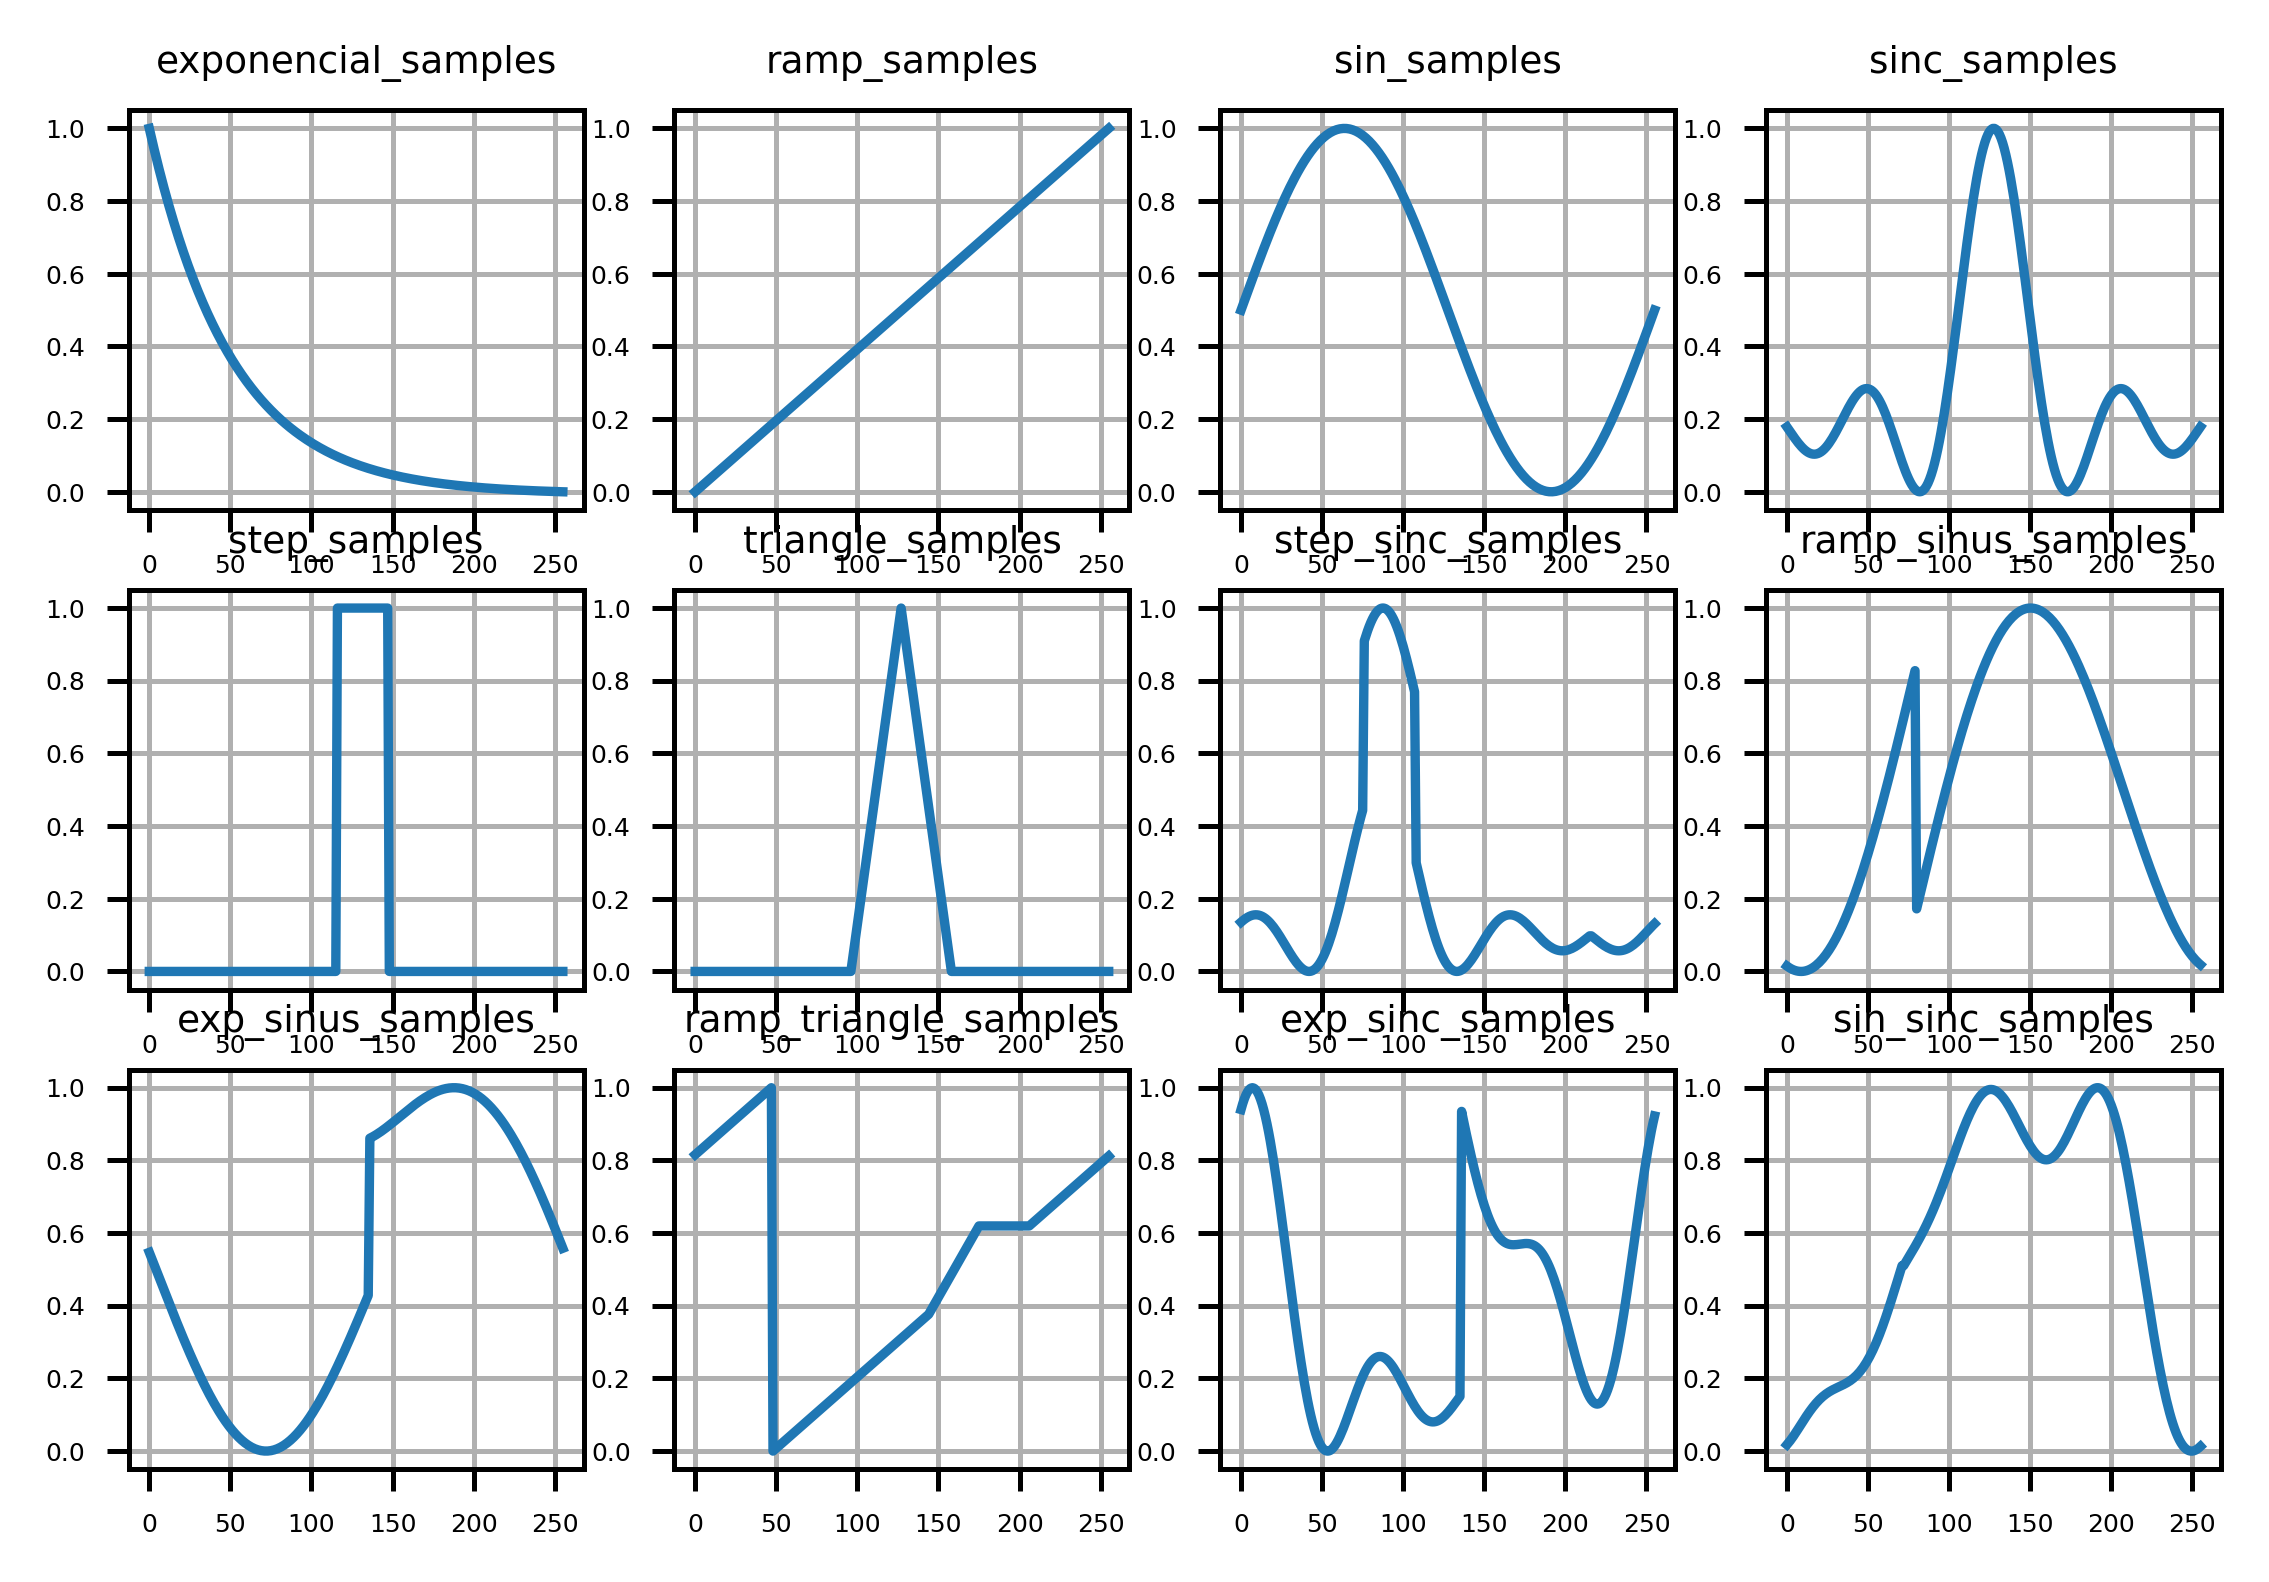

(360, 256)


In [2]:
signals_list = ["exponencial_samples.npy","ramp_samples.npy",\
                "sin_samples.npy","sinc_samples.npy","step_samples.npy",\
                "triangle_samples.npy","step_sinc_samples.npy",\
                "ramp_sinus_samples.npy","exp_sinus_samples.npy",\
                "ramp_triangle_samples.npy","exp_sinc_samples.npy","sin_sinc_samples.npy"]

signals_folder = "../Data"

shifts = 30
signals = np.zeros((len(signals_list)*shifts,256), dtype = np.float64)

# Loading data
for (ii,signal_file) in enumerate(signals_list):
    signals[ii*shifts:(ii+1)*shifts,:] = np.load(os.path.join(signals_folder,signal_file))
    

#Normalizing data between 0 and 1    
signals = (signals-signals.min(axis=1,keepdims = True))/\
          (signals.max(axis=1,keepdims = True)- signals.min(axis=1,keepdims = True))

fig, ax = plt.subplots(nrows=3, ncols=4,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(signals[counter*shifts])
        col.grid()
        col.set_title(signals_list[counter].split(".")[0], fontsize = 6)
        counter+=1
plt.show()

print signals.shape

## Fourier Amplitude Spectrum

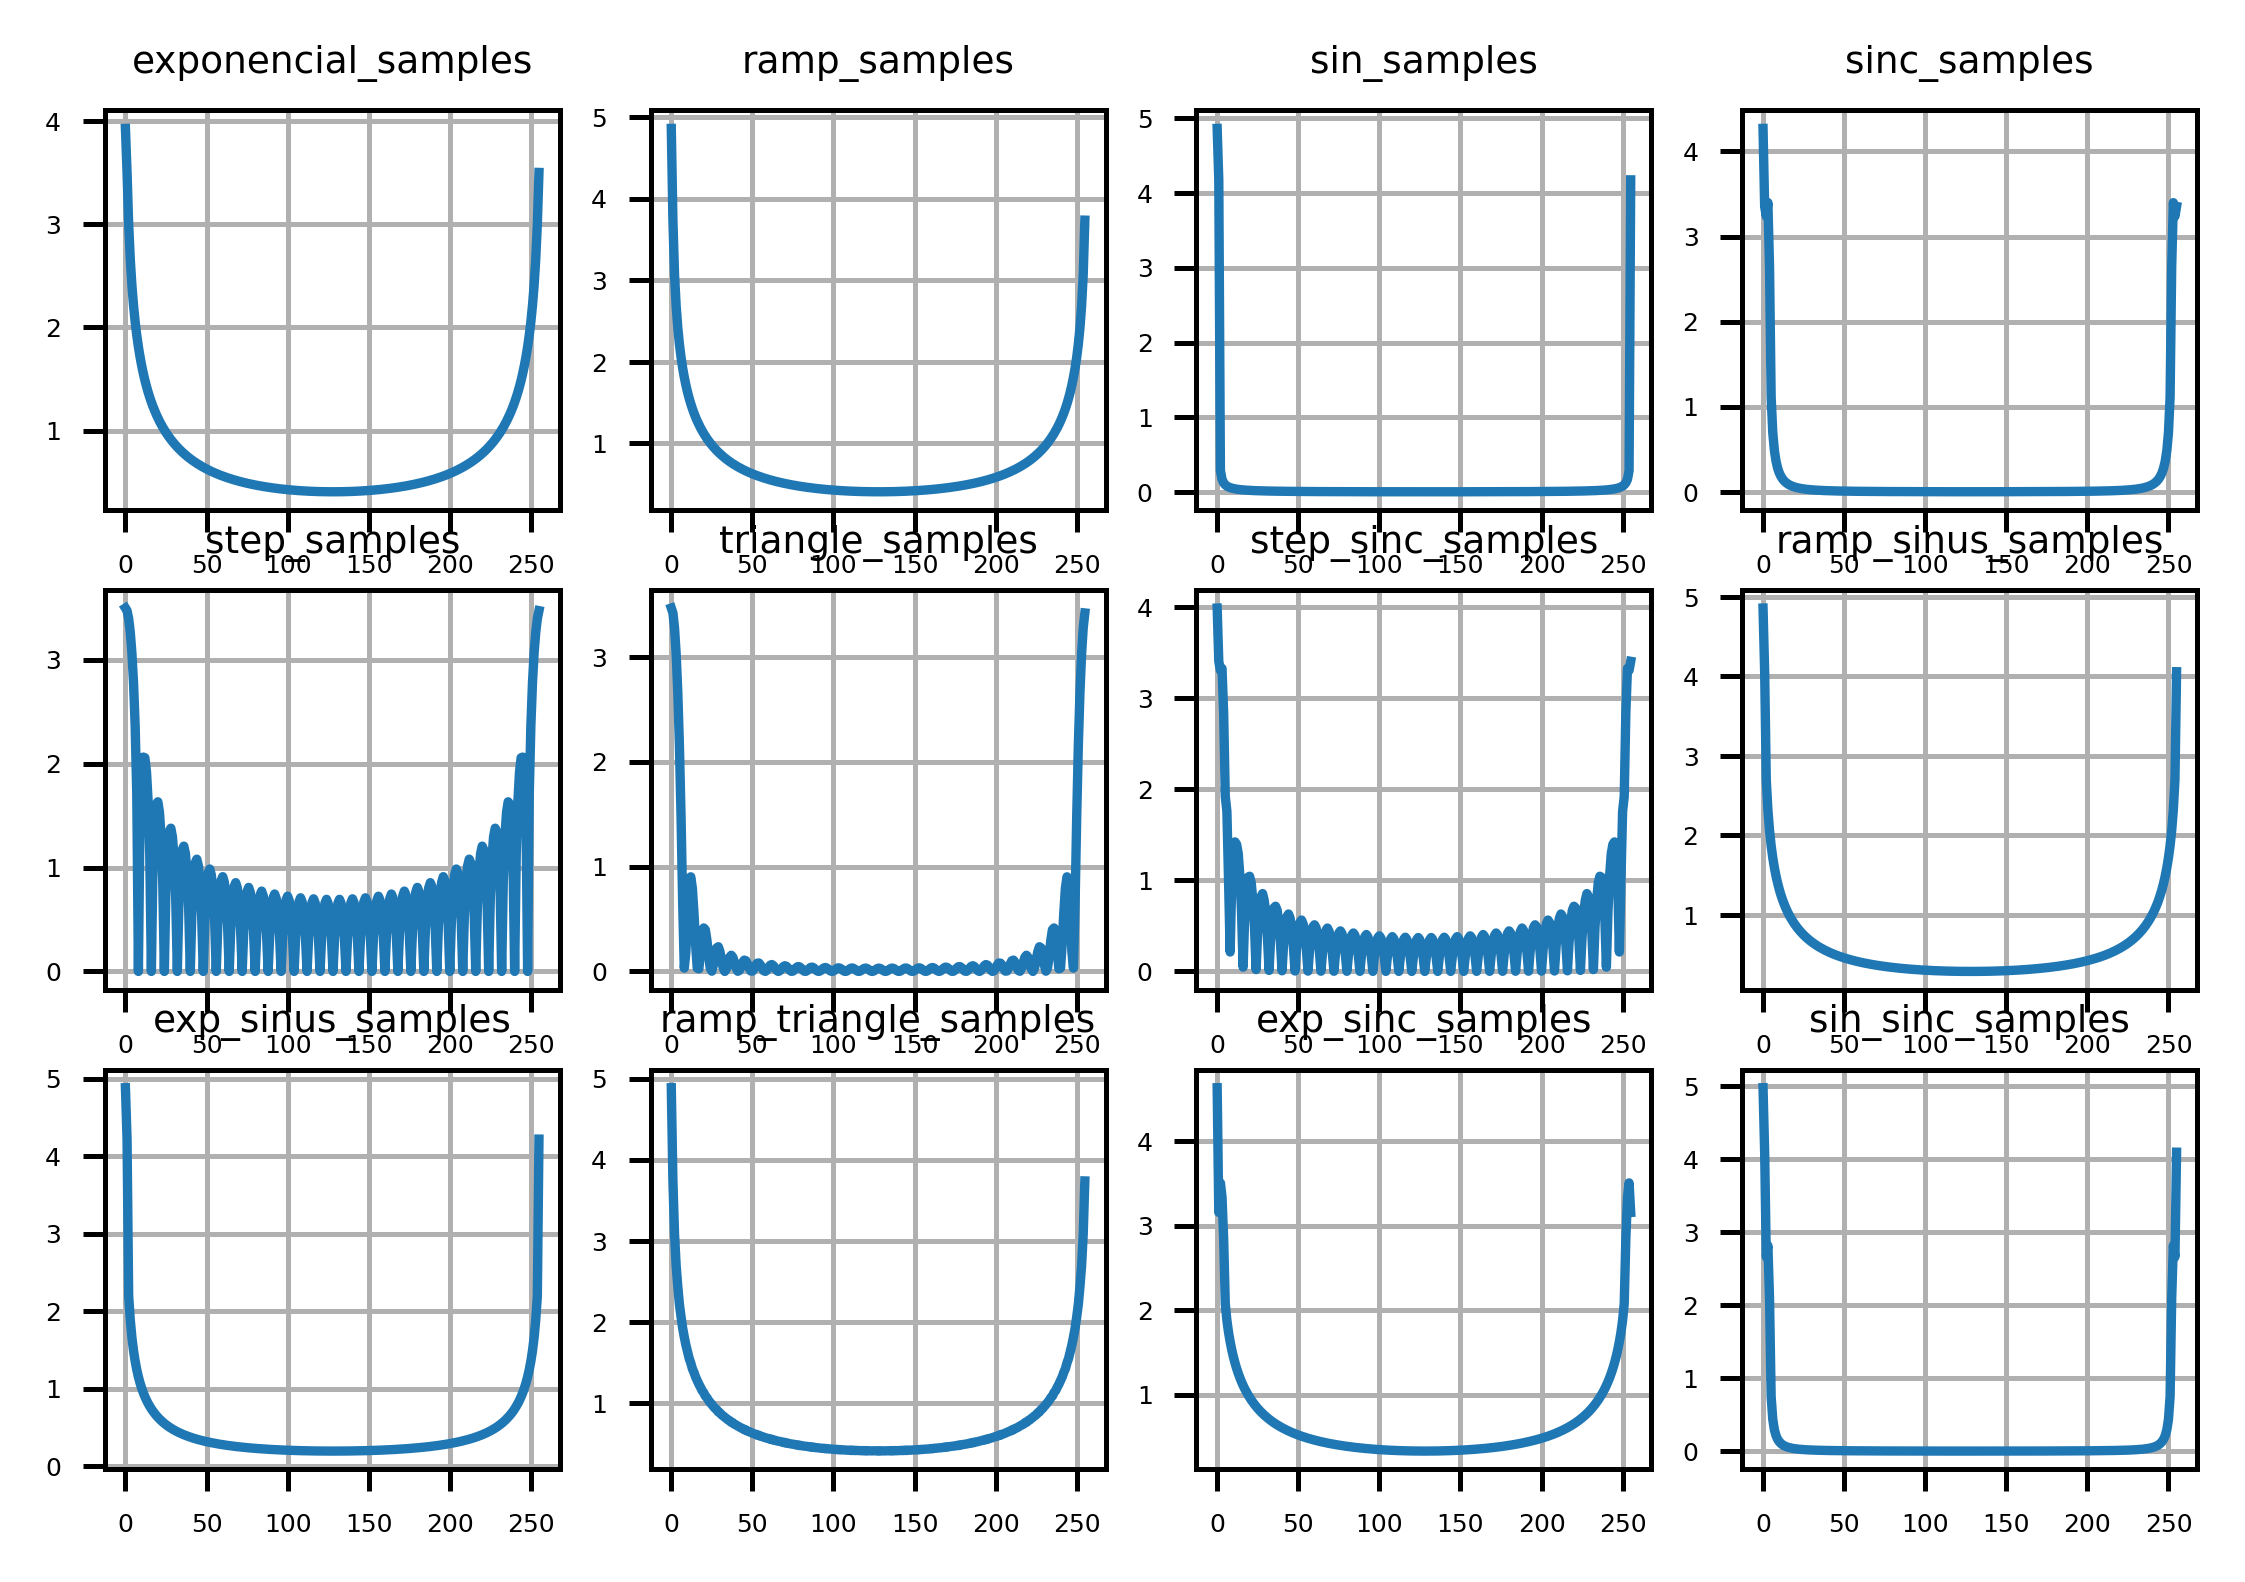

In [3]:
fft_signals = np.fft.fft(signals)
fig, ax = plt.subplots(nrows=3, ncols=4,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(np.log(1+np.abs(fft_signals[counter*shifts])))
        col.grid()
        col.set_title(signals_list[counter].split(".")[0], fontsize = 6)
        counter+=1
plt.show()

## Undersampled Fourier Amplitude Spectrum

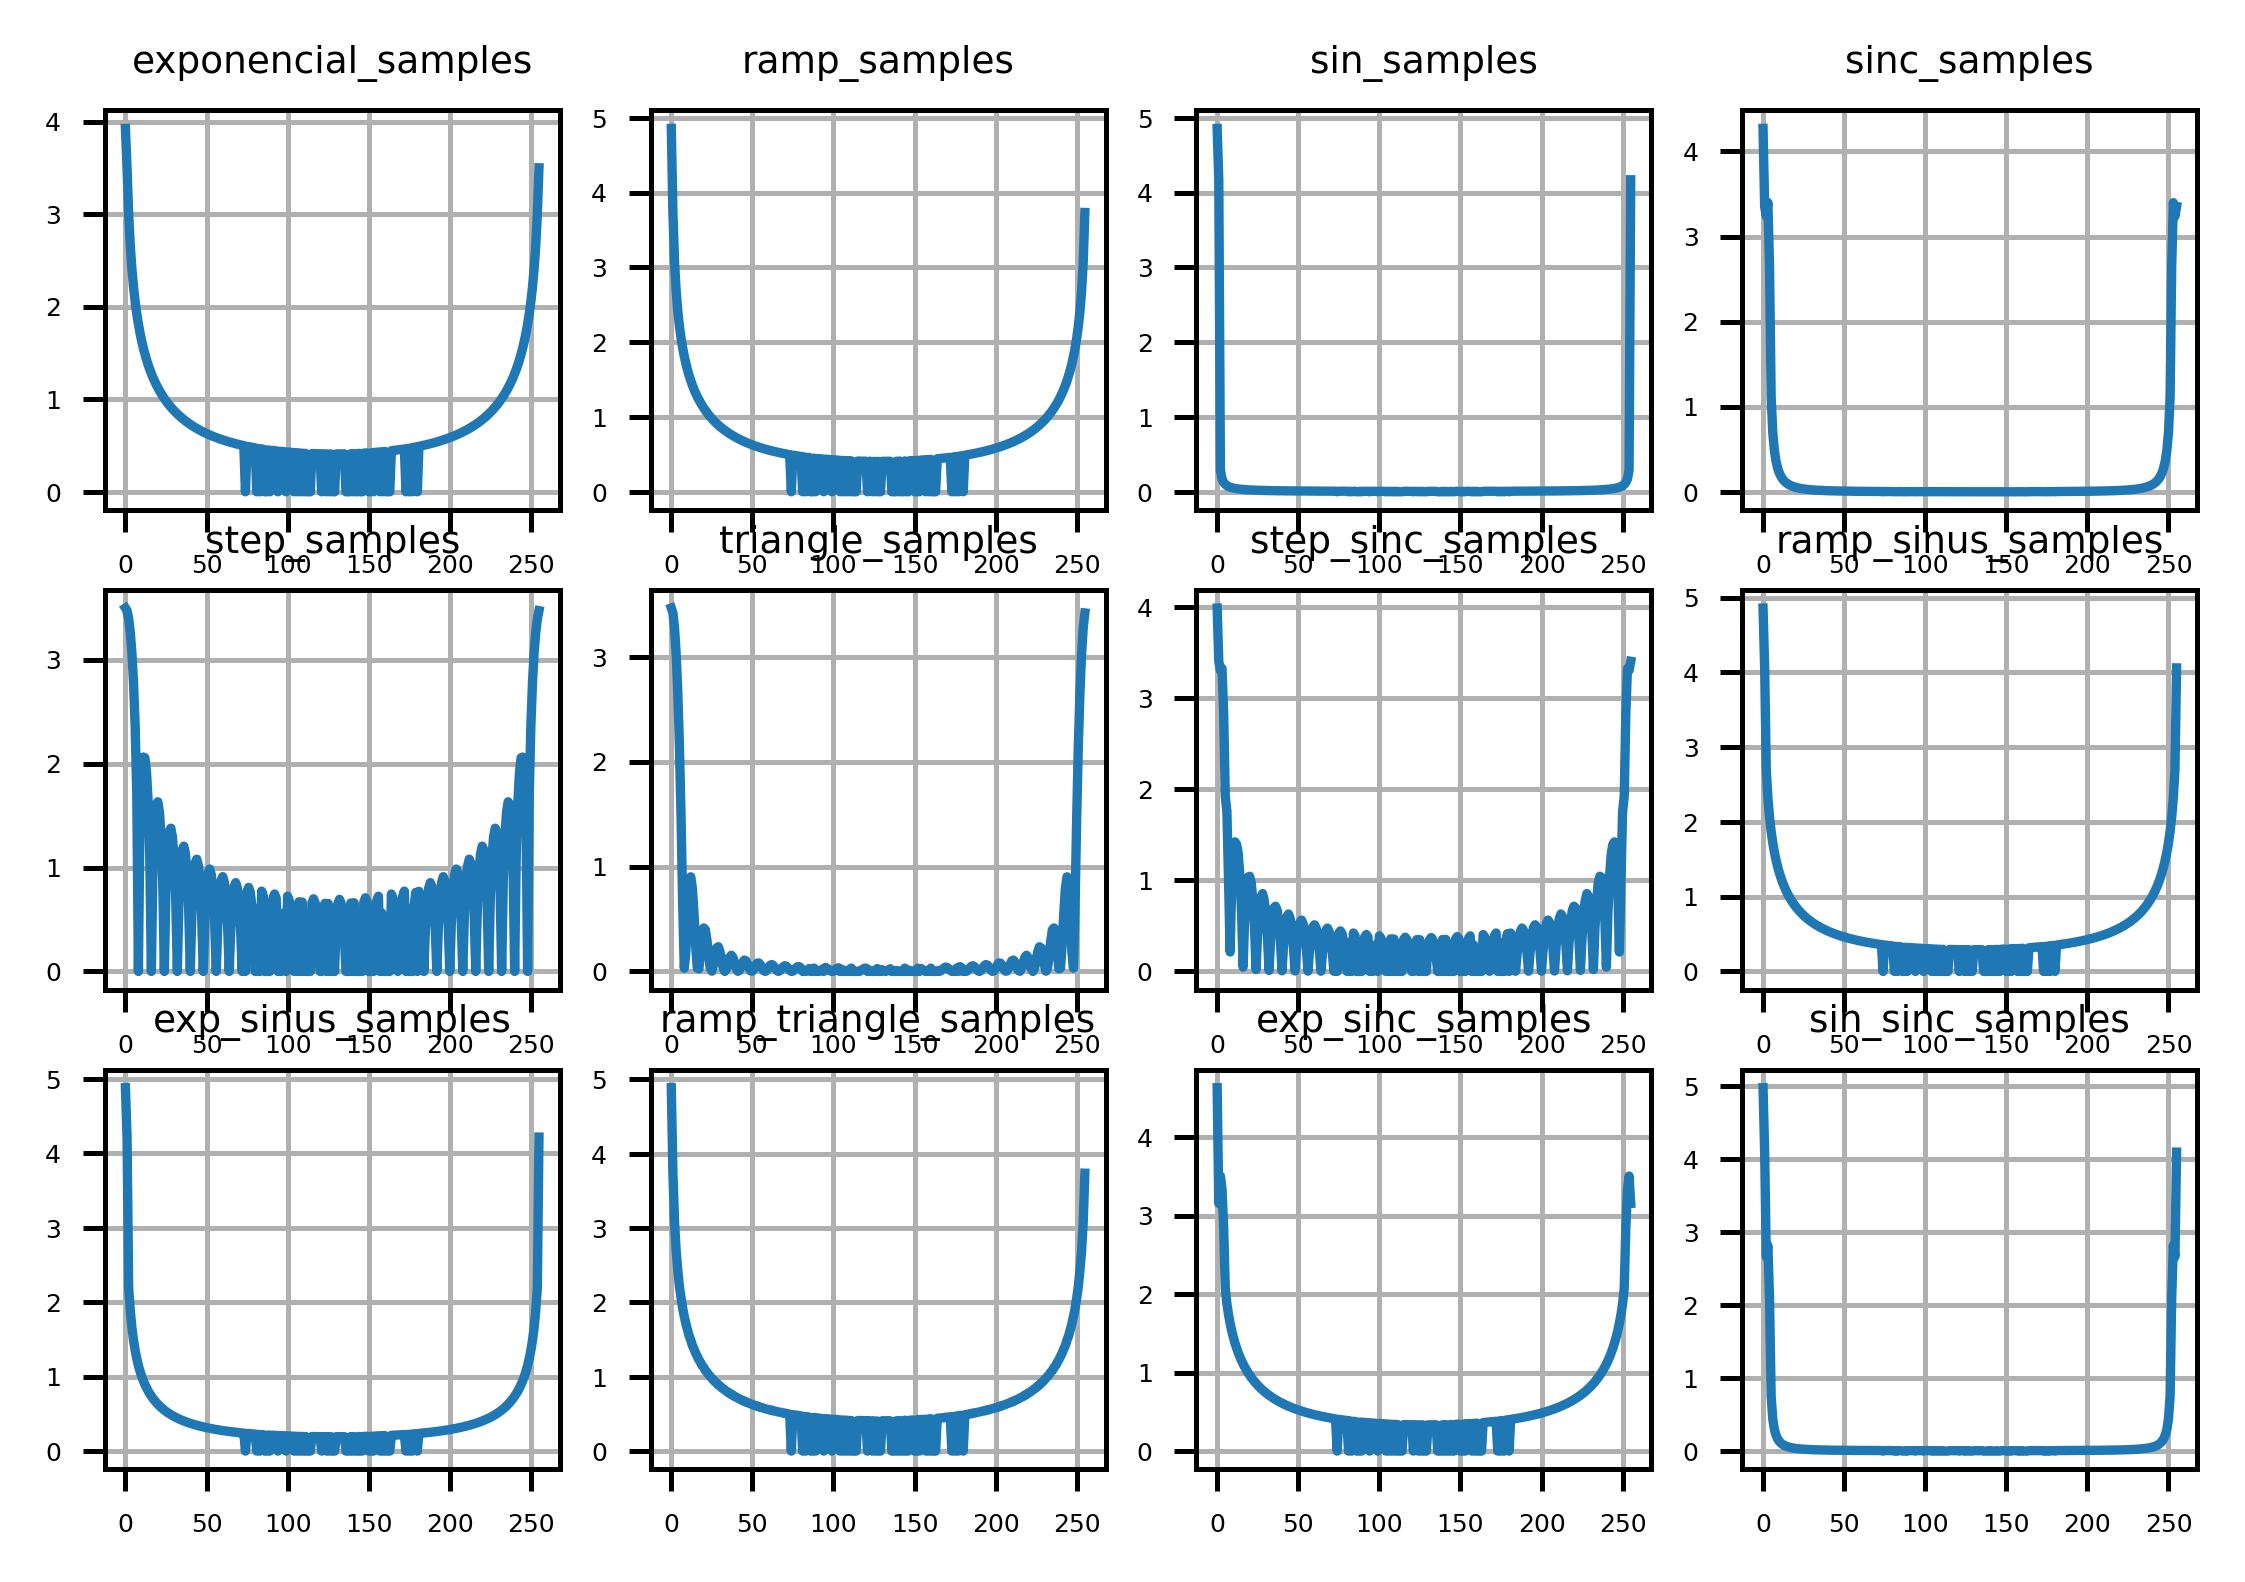

In [4]:
#Random sampling
samples = np.random.choice(np.arange(72,184,dtype = int),40,replace = False)
fft_signals[:,samples] = 0 # putting to 0

fig, ax = plt.subplots(nrows=3, ncols=4,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(np.log(1+np.abs(fft_signals[counter*shifts])))
        col.grid()
        col.set_title(signals_list[counter].split(".")[0], fontsize = 6)
        counter+=1
plt.show()

#Shuffling samples
indexes = np.arange(signals.shape[0],dtype = int)
np.random.shuffle(indexes)
signals = signals[indexes]
fft_signals = fft_signals[indexes]

In [5]:
# Splitting into train and test sets
test_split = int(0.2*signals.shape[0])
signals_train = signals[:-test_split]
signals_test = signals[-test_split:]
fft_signals_train = fft_signals[:-test_split]
fft_signals_test = fft_signals[-test_split:]
#Splitting real and imaginary part and normalizing by the absolute value
# Train set
max_term = np.maximum(np.abs(fft_signals_train.real).max(),np.abs(fft_signals_train.imag).max())

fft_signals_train_split = np.zeros((fft_signals_train.shape[0],2*fft_signals_train.shape[1]))
fft_signals_train_split[:,:fft_signals_train.shape[1]] = fft_signals_train.real/max_term
fft_signals_train_split[:,fft_signals_train.shape[1]:] = fft_signals_train.imag/max_term
# Test
fft_signals_test_split = np.zeros((fft_signals_test.shape[0],2*fft_signals_test.shape[1]))
fft_signals_test_split[:,:fft_signals_test.shape[1]] = fft_signals_test.real/max_term
fft_signals_test_split[:,fft_signals_test.shape[1]:] = fft_signals_test.imag/max_term

In [6]:
def inverse_ft_undersampled_model(learning_rate = 1e-3, learning_decay = 1e-8,gaussian_noise_std = 0.0001):
    inputs = Input(shape=(512,))
    out1 = Dense(2048, activation='relu')(inputs)
    out2 = Dense(2048, activation='relu')(out1)
    out3 = Dense(1024, activation='relu')(out2)
    out4 = Dense(256, activation='relu')(out3)    
    model = Model(inputs=inputs, outputs=out4)
    opt = Adam(lr=learning_rate, decay = learning_decay)
    model.compile(optimizer= opt,loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [7]:
# Early stopping callback to shut down training after 5 epochs with no improvement
earlyStopping = EarlyStopping(monitor='mean_squared_error',
                                        patience=5, 
                                        verbose=1, mode='min')
# Checkpoint callback to save model after each improvement along the epochs
checkpoint = ModelCheckpoint('inverse_ft_under.hdf5', mode = 'min', monitor='mean_squared_error'
                            ,verbose=0, save_best_only=True, save_weights_only = True)

In [8]:
model = inverse_ft_undersampled_model(learning_rate = 1e-3, learning_decay =1e-7)
hist = model.fit(fft_signals_train_split,signals_train,epochs=200,
                 batch_size=64,verbose=2,
                 validation_split=0.25,
                 shuffle = True,
                 callbacks=[checkpoint,earlyStopping])   

Train on 216 samples, validate on 72 samples
Epoch 1/200
 - 1s - loss: 0.2089 - mean_squared_error: 0.2089 - val_loss: 0.1655 - val_mean_squared_error: 0.1655
Epoch 2/200
 - 1s - loss: 0.1363 - mean_squared_error: 0.1363 - val_loss: 0.1295 - val_mean_squared_error: 0.1295
Epoch 3/200
 - 1s - loss: 0.1130 - mean_squared_error: 0.1130 - val_loss: 0.0978 - val_mean_squared_error: 0.0978
Epoch 4/200
 - 1s - loss: 0.0841 - mean_squared_error: 0.0841 - val_loss: 0.0740 - val_mean_squared_error: 0.0740
Epoch 5/200
 - 1s - loss: 0.0670 - mean_squared_error: 0.0670 - val_loss: 0.0618 - val_mean_squared_error: 0.0618
Epoch 6/200
 - 1s - loss: 0.0567 - mean_squared_error: 0.0567 - val_loss: 0.0530 - val_mean_squared_error: 0.0530
Epoch 7/200
 - 1s - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 8/200
 - 1s - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 9/200
 - 1s - loss: 0.0302 - mean_squ

Epoch 72/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 73/200
 - 0s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 00073: early stopping


## Evaluating the Test Set

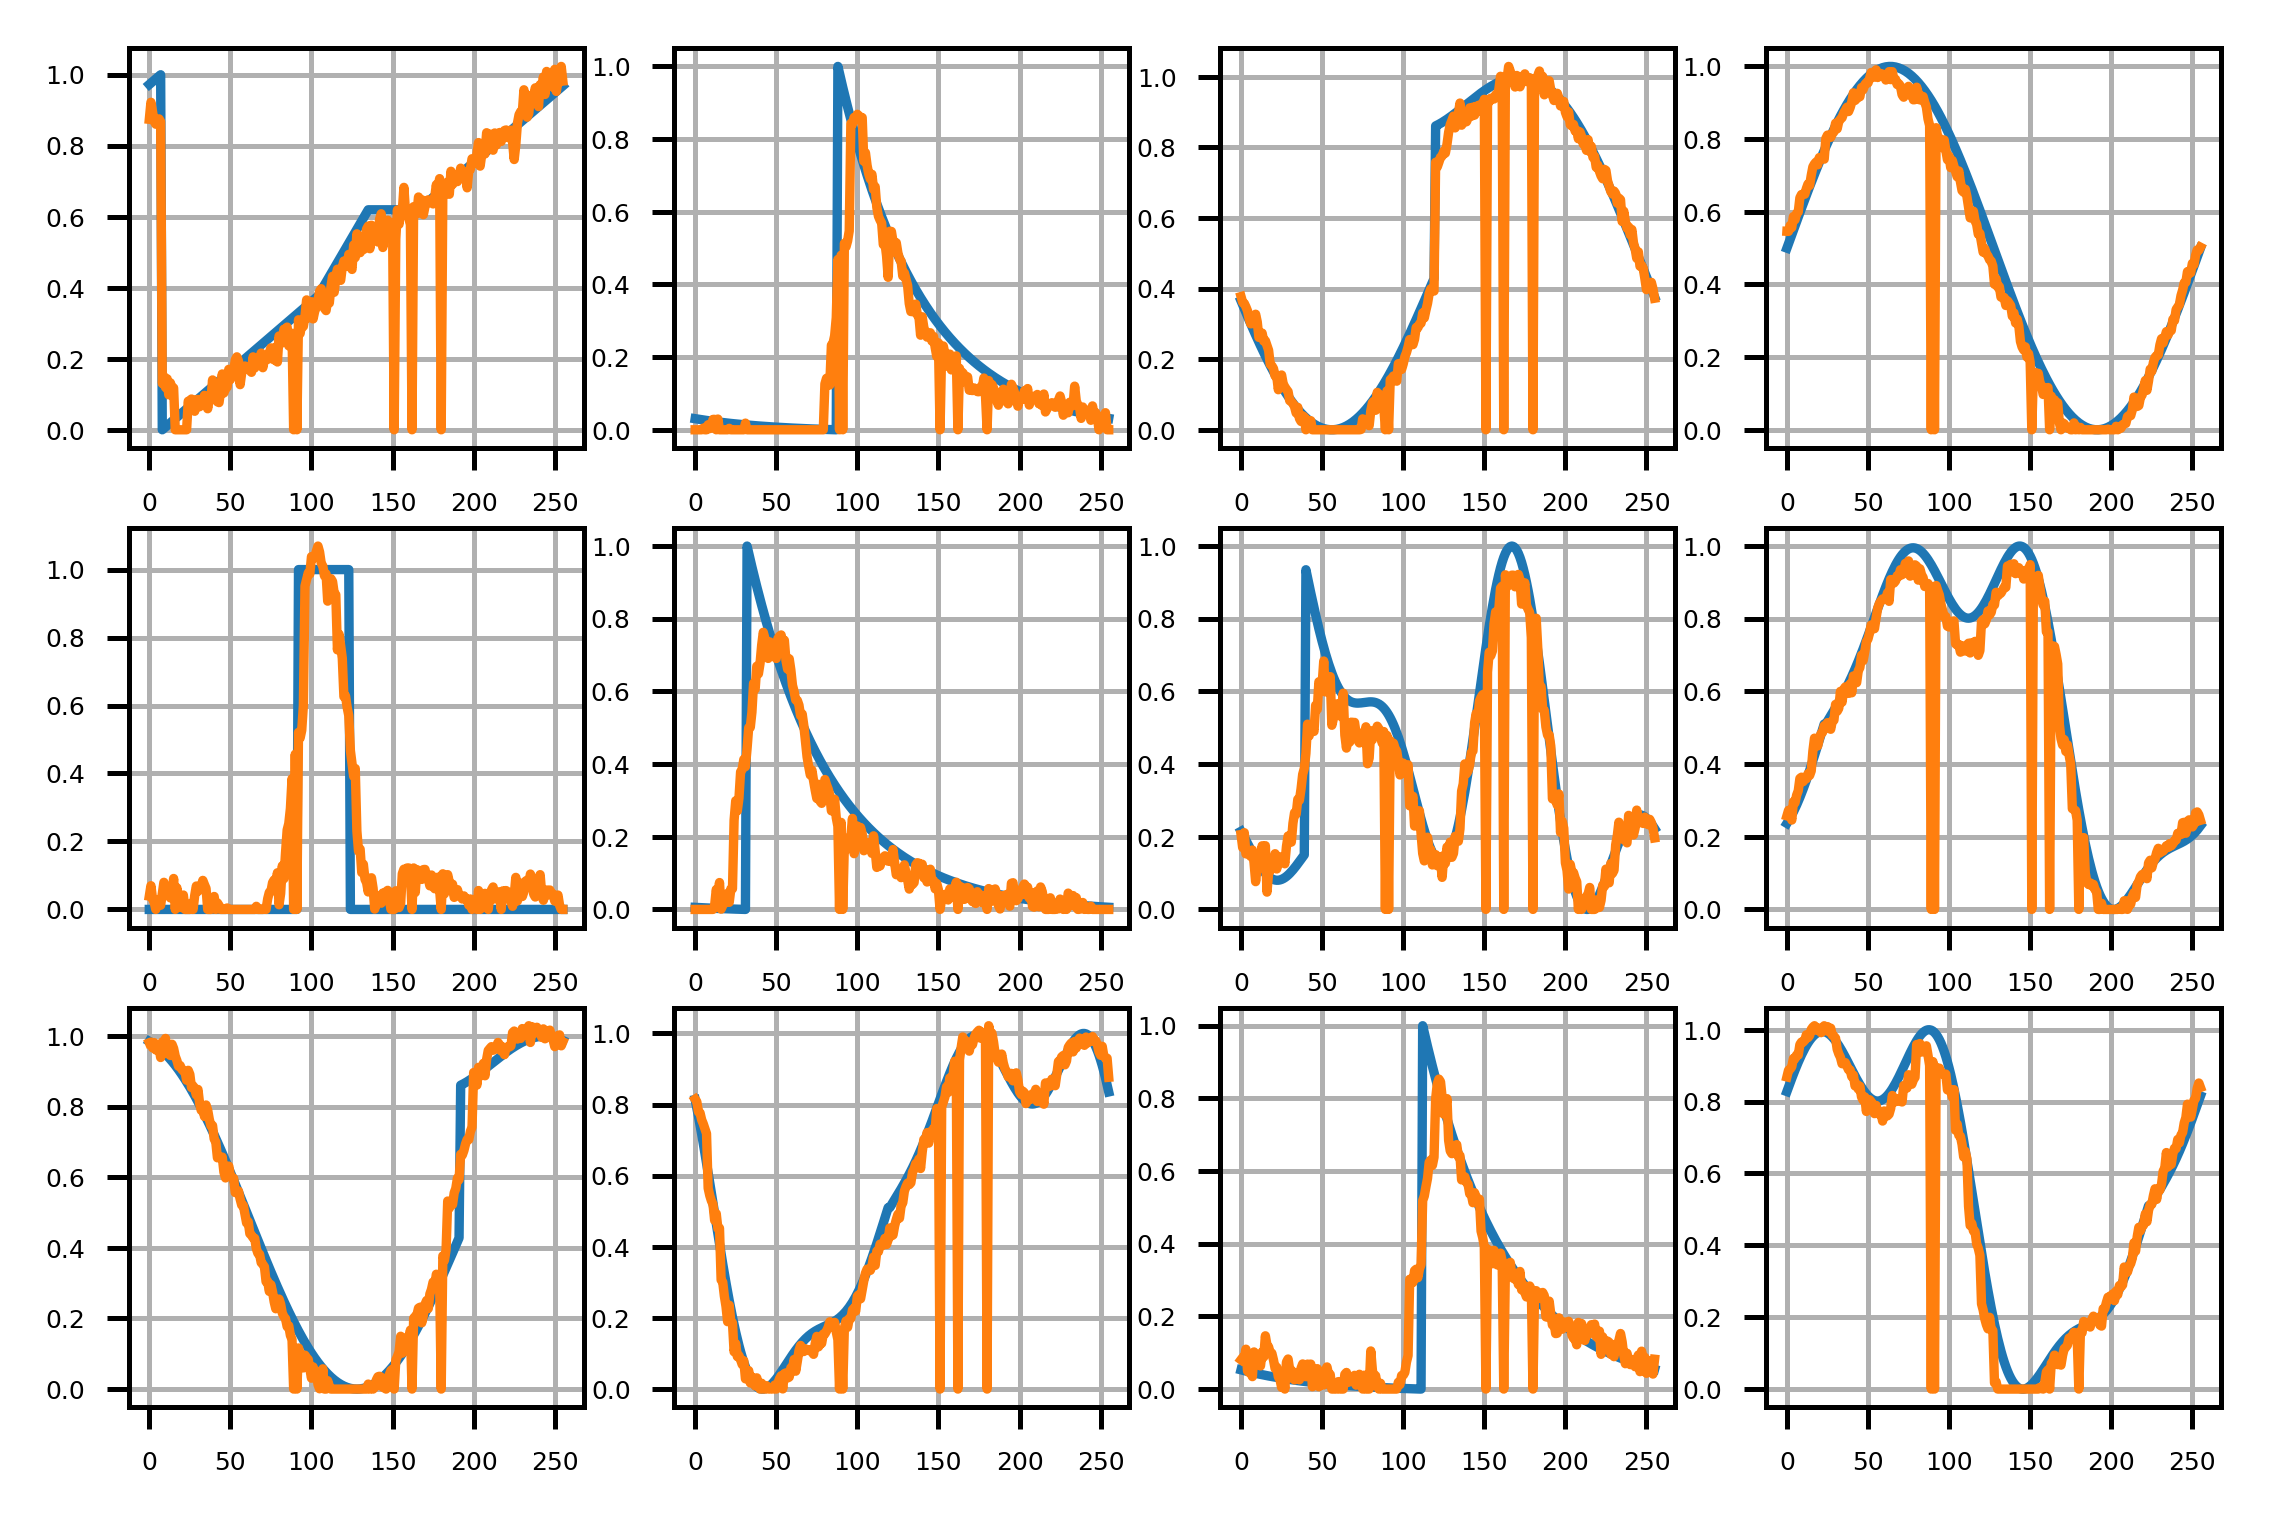

In [11]:
model = inverse_ft_undersampled_model()
model.load_weights('inverse_ft_under.hdf5')
# Evaluate the test set
pred = model.predict(fft_signals_test_split)

fig, ax = plt.subplots(nrows=3, ncols=4,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(signals_test[counter])
        col.plot(pred[counter])
        col.grid()
        counter+=1
plt.show()

## Absolute Error

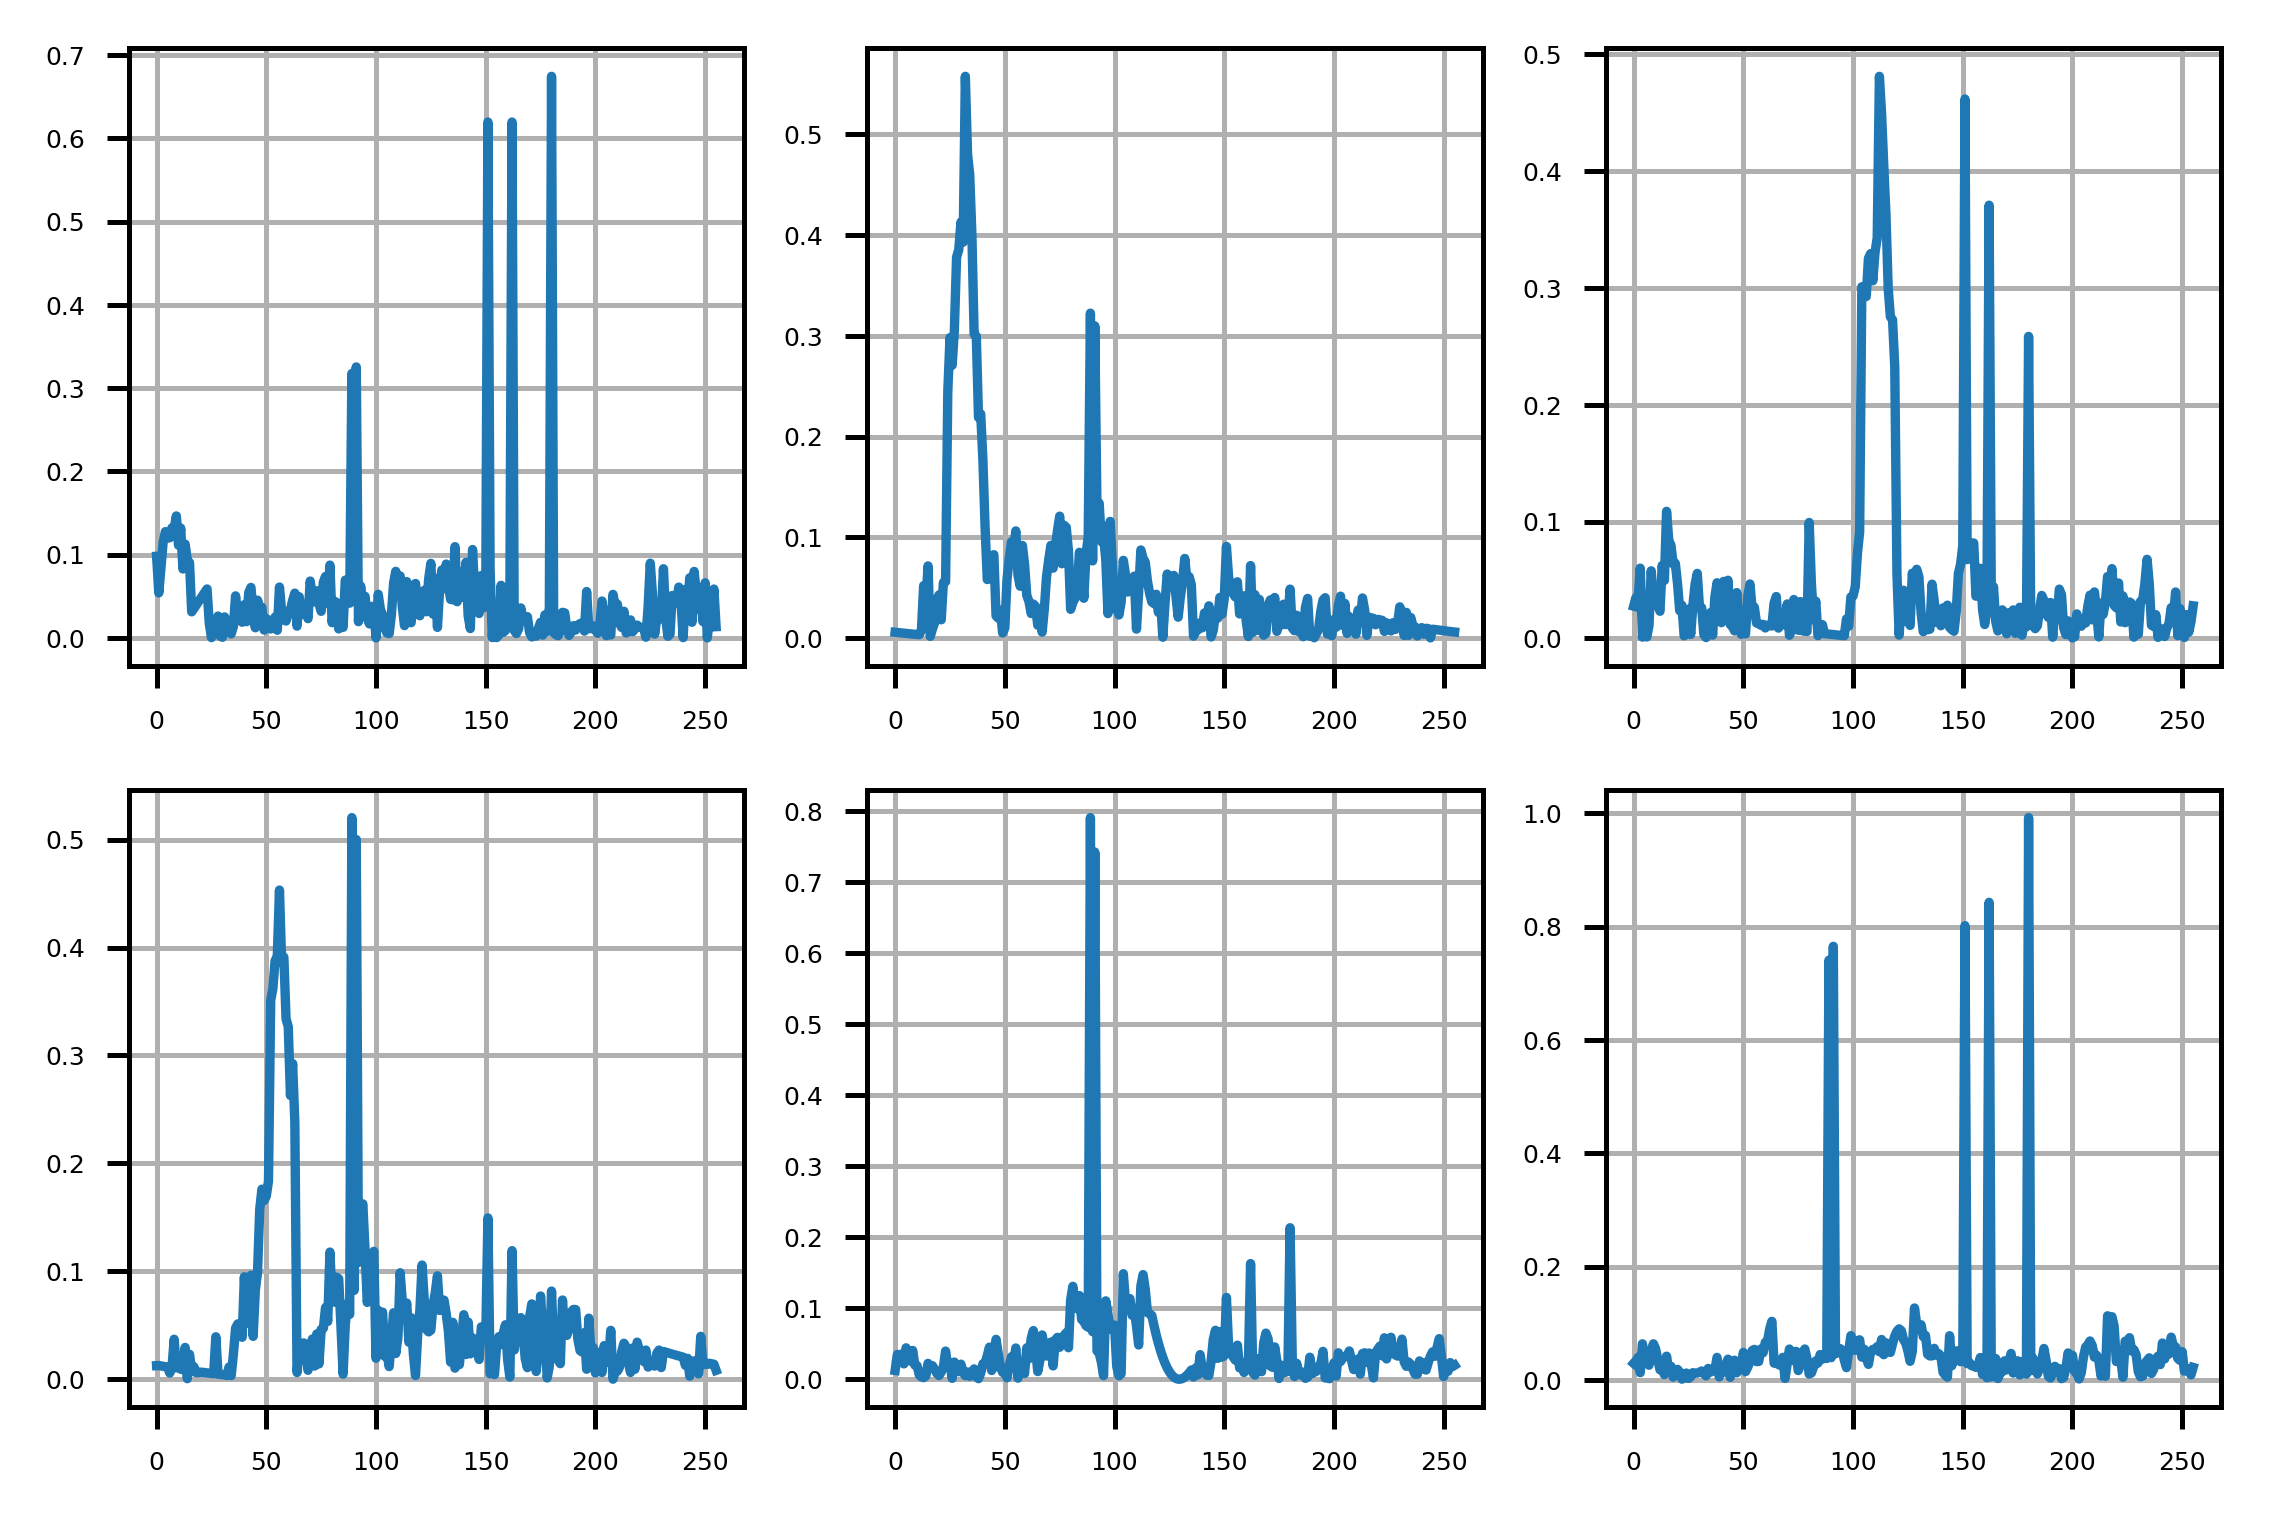

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(np.abs(signals_test[counter]-pred[counter,:256]))
        col.grid()
        counter+=5
plt.show()